In [1]:
%load_ext autoreload
%autoreload 2

## import all packages and libraries

In [2]:
import os
import math

import numpy as np
import matplotlib.pyplot as plt


import librosa
from tqdm.notebook import tqdm

#### Utility functions

In [3]:
def fft(f):
    Ni = len(f)
    Mi = int(Ni / 2)
    if Mi <= 2:
        return [f[0] + f[1] + f[2] + f[3], 
               f[0] - 1j*f[1] - f[2] + 1j*f[3],
               f[0] - f[1] + f[2] - f[3],
               f[0] + 1j*f[1] - f[2] - 1j*f[3]]
    
    wn = math.cos(2*math.pi/Ni) - 1j*math.sin(2*math.pi/Ni)
    fe = [f[i] for i in range(Ni) if i % 2 == 0]
    fo = [f[i] for i in range(Ni) if i % 2 == 1]
    Fe = fft(fe)
    Fo = fft(fo)
    return [np.around(Fe[i] + (wn**i)*Fo[i], decimals=10) for i in range(Mi)] + [np.around(Fe[i] - (wn**i)*Fo[i], decimals=10) for i in range(Mi)]

def get_audio_data(filename):
    fs = 2**12 # sample rate
    tp = 2 # sampling duration
    N = n = fs*tp # number of samples
    
    # Extract data and sampling rate from file
    recording, fs = librosa.load(filename, sr=fs, duration=tp, mono=True)
    n = len(recording)        
    tp = int(n / fs)

    if tp < 2:
        pad_width = N - len(recording)
        recording = np.pad(recording, pad_width=((0, pad_width),), mode='constant')

        n = len(recording)
        tp = int(n / fs)

    N = fs*tp # number of samples
    x = [np.round(float(recording[i]), 10) for i in range(n)] # input sequence
    return x, tp, n

def get_top_frequencies(fi, X_amp, size):
    fi = np.array(fi)
    X_amp = np.array(X_amp)
    
    return fi[np.argsort(X_amp)[::-1][:size]]

def get_frequency_amplitude(x, tp, N):
    _X = fft(x) # discrete Fourier transform
    X = [np.round(Xi/N, 10) for Xi in _X] # frequency spectrum
    X_amp = [np.absolute(Xi) for Xi in X] # amplitude spectrum

    M = int(N/2)
    ti = np.array([i*tp/N for i in range(N)])
    fi = np.array([i/tp for i in range(M)])
    X_amp = np.array(X_amp[:M])*2
    
    return ti, fi, X_amp

def extract_features(filepath):
    # try:
    audio_features = get_audio_data(filepath)
    if not audio_features:
        return

    x, tp, N = audio_features
    ti, fi, X_amp = get_frequency_amplitude(x, tp, N)
    return fi, X_amp

def get_data(data_dir: str, callback = lambda x: x) -> np.array:
    # feature list
    X, y = [], []

    # Iterate through each sound file and extract the features 
    for folder in tqdm(os.listdir(data_dir)):
        class_label = folder
        
        if class_label.startswith("0"):
            continue
            
        for file in os.listdir(os.path.join(data_dir, folder)):
            file_name = os.path.join(os.path.join(data_dir, folder, file))

            X.append(callback(file_name))
            y.append(class_label)
    
    X, y = map(np.array, [X, y])
    return X, y

def extract_features2(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=3) 
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    
#     pad_width = 256 - mfccs.shape[1]
#     mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')     
    
    mfccs = mfccs.mean(1)
    return np.arange(len(mfccs)), mfccs

def plot_wave(ti, x, fi, X_amp):
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    ax1= plt.subplot(211)
    plt.plot(ti, x)
    plt.xlabel('t (seconds)')
    plt.ylabel('x(t)')
    plt.minorticks_on()
    plt.grid(b=True, which='major', linestyle='-')
    plt.grid(b=True, which='minor', linestyle='--')

    ax2 = plt.subplot(212)
    plt.plot(fi, X_amp)
    plt.xlabel('f (hertz)')
    plt.ylabel('|X(f)|')
    ax2.set_xscale('log')
    plt.minorticks_on()
    plt.grid(b=True, which='major', linestyle='-')
    plt.grid(b=True, which='minor', linestyle='--')

    plt.show()

#### CONSTANTS

In [4]:
# DATA_DIR = os.path.join("data" , "old_guitar_sample")
DATA_DIR = os.path.join("data" , "guitar_sample")

In [5]:
input_data, output_data = get_data(DATA_DIR, extract_features)

In [56]:
label = None

if label is None:
    is_label = f"1A"
    not_label = f"1G"
    X, y = input_data, output_data
    
else:
    is_label = f"1{label}"
    not_label = f"0{label}"

    indices1 = np.where(output_data == is_label)[0]
    indices2 = np.where(output_data != is_label)[0]

    np.random.shuffle(indices2)
    indices2 = indices2[:len(indices1)]
    indices = np.concatenate([indices1, indices2])

    X = input_data[indices]
    y = output_data[indices]
    y[-len(indices1):] = not_label

X.shape

(118, 2, 4096)

In [58]:
index1 = np.where(y == is_label)[0][10]
index2 = np.where(y == not_label)[0][0]

In [59]:
np.where(y == not_label)[0]

array([ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117], dtype=int64)

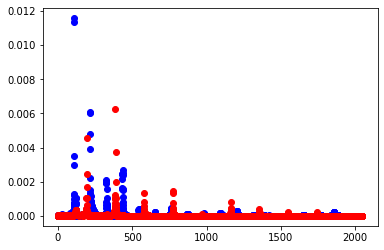

In [61]:
plt.scatter(X[index1, 0, :], X[index1, 1, :], color="blue")
plt.scatter(X[index2, 0, :], X[index2, 1, :], color="red")

In [62]:
def get_outlier_amplitude_frequency(freq, amplitude):
    # calculate interquartile range
    q25, q75 = np.percentile(amplitude, 25), np.percentile(amplitude, 75)
    iqr = q75 - q25
#     print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.8f' % (q25, q75, iqr))

    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    # identify outliers
    outlier_freq = freq[(amplitude < lower) | (amplitude > upper)]
    print(f'Identified outliers: {len(outlier_freq):d}, min = {outlier_freq.min():8.2f}, max = {outlier_freq.max():8.2f}, mean = {outlier_freq.mean():8.2f}')

get_outlier_amplitude_frequency(X[0, 0, :], X[0, 1, :])

Identified outliers: 483, min =    17.50, max =  1863.50, mean =   441.42


In [65]:
indices = np.random.randint(len(y), size=10)
indices = np.where(y == is_label)[0]

for index in indices:
    print(f"{y[index]:>3s}: {X[index, 0][X[index, 1].argmax()]:5.2f}", end=" ")
    get_outlier_amplitude_frequency(X[index, 0, :], X[index, 1, :])

 1A: 108.50 Identified outliers: 483, min =    17.50, max =  1863.50, mean =   441.42
 1A: 108.00 Identified outliers: 478, min =     0.00, max =  1853.00, mean =   438.46
 1A: 108.50 Identified outliers: 463, min =    16.00, max =  1868.50, mean =   524.96
 1A: 108.00 Identified outliers: 471, min =    16.00, max =  1865.00, mean =   512.37
 1A: 108.00 Identified outliers: 489, min =    15.00, max =  1865.00, mean =   550.42
 1A: 108.00 Identified outliers: 479, min =    15.00, max =  1861.00, mean =   508.74
 1A: 108.50 Identified outliers: 495, min =    10.50, max =  1865.00, mean =   512.64
 1A: 108.50 Identified outliers: 486, min =    17.50, max =  1867.50, mean =   522.38
 1A: 108.50 Identified outliers: 488, min =    15.50, max =  1873.50, mean =   529.42
 1A: 108.50 Identified outliers: 473, min =    17.50, max =  1881.00, mean =   535.86
 1A: 108.00 Identified outliers: 457, min =    17.50, max =  1863.50, mean =   497.36
 1A: 108.50 Identified outliers: 488, min =    17.00, 

In [66]:
# indices = np.random.randint(len(y), size=20)
indices = np.where(y == not_label)[0]

for index in indices:
    print(f"{y[index]:>3s}: {X[index, 0][X[index, 1].argmax()]:5.2f}", end=" ")
    get_outlier_amplitude_frequency(X[index, 0, :], X[index, 1, :])

 1G: 387.00 Identified outliers: 508, min =    16.00, max =  1746.00, mean =   443.36
 1G: 193.00 Identified outliers: 533, min =    10.50, max =  1940.00, mean =   384.83
 1G: 193.00 Identified outliers: 521, min =    16.00, max =  1939.50, mean =   393.51
 1G: 387.50 Identified outliers: 512, min =    15.50, max =  1940.50, mean =   413.38
 1G: 193.00 Identified outliers: 505, min =    17.00, max =  1940.00, mean =   383.91
 1G: 387.50 Identified outliers: 428, min =    97.50, max =  1940.50, mean =   433.01
 1G: 193.50 Identified outliers: 469, min =    17.00, max =  1940.00, mean =   412.12
 1G: 193.00 Identified outliers: 512, min =    14.50, max =  1939.50, mean =   371.34
 1G: 387.50 Identified outliers: 503, min =    16.00, max =  1747.50, mean =   425.01
 1G: 193.00 Identified outliers: 481, min =    16.00, max =  1940.50, mean =   413.24
 1G: 193.00 Identified outliers: 535, min =    17.00, max =  1748.00, mean =   414.24
 1G: 387.50 Identified outliers: 483, min =   105.00, 

In [68]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y_train_le = le.fit(y)

le.classes_

array(['1A', '1B', '1D', '1EH', '1EL', '1G'], dtype='<U3')

In [89]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit

# split train and test data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=100)
for train_index, test_index in sss.split(X, y):
    x_train, x_test = X[:, 1][train_index], X[:, 1][test_index]
    y_train_label, y_test_label = y[train_index], y[test_index]
    y_train, y_test = map(le.transform, [y_train_label, y_test_label])
    
    
clf = KNeighborsClassifier(n_neighbors=3, weights="distance")
clf.fit(x_train, y_train_label)

clf.fit(x_train, y_train_label)
print(f"training accuracy = {clf.score(x_train, y_train_label):.2f}")
print(f"test accuracy = {clf.score(x_test, y_test_label):.2f}")

training accuracy = 1.00
test accuracy = 1.00


In [87]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(x_test)
confusion_matrix(y_test_label, y_pred)

array([[5, 0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0, 0],
       [0, 0, 5, 0, 0, 0],
       [0, 0, 0, 5, 0, 0],
       [0, 0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0, 5]], dtype=int64)

In [71]:
from sklearn.metrics import classification_report

print(classification_report(y_test_label, y_pred))

              precision    recall  f1-score   support

          1A       1.00      1.00      1.00         5
          1B       1.00      1.00      1.00         5
          1D       1.00      1.00      1.00         5
         1EH       1.00      1.00      1.00         5
         1EL       1.00      1.00      1.00         5
          1G       1.00      1.00      1.00         5

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [72]:
x_test_sample = []
y_test_sample = []

sample_dirs = ["EH", "D", "A", "B", "G", "EL"]
# sample_dirs = ["A"]

for class_label in tqdm(sample_dirs):
    print(class_label, end=", ")
    labeldir= os.path.join("data", "old_guitar_sample", class_label)

    for filename in (os.listdir(labeldir)):
        anchor_filepath = os.path.join("data", "old_guitar_sample", class_label, filename)
        
        anchor_file_vector = extract_features(anchor_filepath)
        x_test_sample.append(anchor_file_vector[1])
        if label is None:
            y_test_sample.append(f"1{class_label}")
        
        else:
            y_test_sample.append(f"1{label}" if label == class_label else f"0{label}")

print()
x_test_sample = np.array(x_test_sample)
y_test_sample = np.array(y_test_sample)

print(x_test_sample.shape)

EH, D, A, B, G, EL, 

(58, 4096)


In [73]:
print(f"test accuracy = {clf.score(x_test_sample, y_test_sample):.2f}")

test accuracy = 0.98


In [74]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(x_test_sample)
confusion_matrix(y_test_sample, y_pred)

array([[ 9,  0,  1,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0],
       [ 0,  0, 10,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0],
       [ 0,  0,  0,  0,  9,  0],
       [ 0,  0,  0,  0,  0,  9]], dtype=int64)

In [75]:
from sklearn.metrics import classification_report

print(classification_report(y_test_sample, y_pred))

              precision    recall  f1-score   support

          1A       1.00      0.90      0.95        10
          1B       1.00      1.00      1.00        10
          1D       0.91      1.00      0.95        10
         1EH       1.00      1.00      1.00        10
         1EL       1.00      1.00      1.00         9
          1G       1.00      1.00      1.00         9

    accuracy                           0.98        58
   macro avg       0.98      0.98      0.98        58
weighted avg       0.98      0.98      0.98        58



In [81]:
sample_fi, sample_amp = extract_features(os.path.join(DATA_DIR, "..", "sampleG.wav"))

print(f'{"1A":>3s}: {sample_fi[sample_amp.argmax()]:5.2f}', end=" ")
get_outlier_amplitude_frequency(sample_fi, sample_amp)

 1A: 778.00 Identified outliers: 366, min =   102.00, max =  1950.00, mean =   830.13


In [90]:
X[:, 1].shape, sample_amp.shape

((118, 4096), (4096,))

In [91]:
print(clf.predict([sample_amp]))

['1G']


In [92]:
print(clf.predict_proba([sample_amp]))

[[0. 0. 0. 0. 0. 1.]]


In [93]:
clf.classes_

array(['1A', '1B', '1D', '1EH', '1EL', '1G'], dtype='<U3')